In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
sequence_length = 4
batch_size = 1
input_dim = 512 # features for every word
d_model = 512 # output of attention model for every word
x = torch.randn((batch_size, sequence_length, input_dim))


In [4]:
x.size()

torch.Size([1, 4, 512])

In [5]:
qkv_layer = nn.Linear(input_dim, 3 * d_model)

In [6]:
qkv = qkv_layer(x)

In [7]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

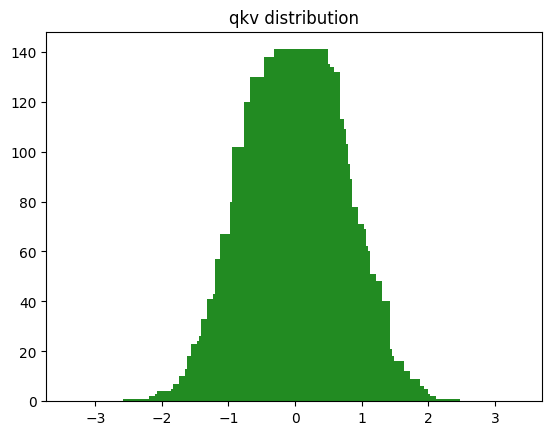

In [8]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins = 200, min =-3, max = 3)
x_val = np.arange(-1,1,0.01)*3
plt.bar(x_val,y_val,align='center', color='forestgreen')
plt.title('qkv distribution')

In [9]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3*head_dim)

In [10]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [11]:
qkv = qkv.permute(0,2,1,3) # [batch_size, num_heads, seq_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [12]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [13]:
import math
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2,-1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [14]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal =1)
mask[0][1] # mask for input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [15]:
mask.shape

torch.Size([1, 8, 4, 4])

In [16]:
scaled += mask
scaled[0][0]

tensor([[ 0.3681,    -inf,    -inf,    -inf],
        [ 0.0513, -0.4260,    -inf,    -inf],
        [ 0.1146,  0.2172,  0.2196,    -inf],
        [-0.3970,  0.7354,  0.6916,  0.3154]], grad_fn=<SelectBackward0>)

In [17]:
attention = F.softmax(scaled, dim = -1)
attention.shape, attention[0][0]

(torch.Size([1, 8, 4, 4]),
 tensor([[1.0000, 0.0000, 0.0000, 0.0000],
         [0.6171, 0.3829, 0.0000, 0.0000],
         [0.3107, 0.3442, 0.3451, 0.0000],
         [0.1097, 0.3406, 0.3260, 0.2237]], grad_fn=<SelectBackward0>))

In [18]:
values = attention @ v
values.shape

torch.Size([1, 8, 4, 64])

Functions

In [19]:
import math

def scaled_dot_product(q,k,v,mask=None):
    d_k = q.size()[-1]
    scaled = (q @ k.transpose(-2,-1)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim =-1)
    values = attention @ v
    return values, attention

In [20]:
values, attention = scaled_dot_product(q,k,v,mask=mask)
attention.shape, attention[0][0]

(torch.Size([1, 8, 4, 4]),
 tensor([[1.0000, 0.0000, 0.0000, 0.0000],
         [0.6171, 0.3829, 0.0000, 0.0000],
         [0.3107, 0.3442, 0.3451, 0.0000],
         [0.1097, 0.3406, 0.3260, 0.2237]], grad_fn=<SelectBackward0>))

In [21]:
values.size()

torch.Size([1, 8, 4, 64])

In [22]:
# concat the heads
values = values.reshape(batch_size, sequence_length, num_heads*head_dim)
values.size()

torch.Size([1, 4, 512])

In [23]:
linear_layer = nn.Linear(d_model, d_model)
out = linear_layer(values)
out.shape

torch.Size([1, 4, 512])

# Put Everything Together!!

B-> batch size; T-> seq length; head dim -> d_model/n_heads; n_embed = d_model = num_heads * head_dim
- Get x -> token embedding + positional embedding -> [B, T, n_embed]
- Get qkv -> linear layer(n_embed, 3 * d_model (attention model out size))
- Pass x to qkv layer -> [B, T, 3 * d_model]
- Break qkv to split it across all heads -> [B, T, num_heads, 3 * head dim]
- Permute [B, T, num_heads, 3 * head dim] -> [B, num_heads, T, 3 * head dim]
- Split q,k,v -> [B, num_heads, T, head_dim]
- Scaled dot prod attention:
    - values -> [B, num_heads, T, head_dim]
    - attention -> [B, num_heads, T, T]
- Concatenate heads in value -> [B, T, num_heads * head_dim]
- Output linear layer -> [B, T, num_heads * head_dim]

In [24]:
import math
import torch.nn as nn
import torch

def scaled_dot_product(q,k,v,mask=None):
    d_k = q.size()[-1]
    scaled = (q @ k.transpose(-2,-1)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim =-1)
    values = attention @ v
    return values, attention

In [35]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim, 3*d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"{x.size()= }")
        qkv = self.qkv_layer(x)
        print(f"{qkv.size()= }")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3*self.head_dim)
        print(f"{qkv.size()= }")
        qkv = qkv.permute(0,2,1,3)
        print(f"{qkv.size()= }")
        q, k, v = qkv.chunk(3, dim =-1)
        print(f"{q.size()= } {k.size()= } {v.size()= }")
        values,attention = scaled_dot_product(q,k,v,mask)
        print(f"{values.size()= } {attention.size()= }")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"{values.size()= }")
        out = self.linear_layer(values)
        print(f"{out.size()= }")
        return out

In [36]:
input_dim = 1024
d_model = 512
num_heads = 8
batch_size = 30
sequence_length = 5
x = torch.randn((batch_size, sequence_length, input_dim))
model = MultiHeadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size()= torch.Size([30, 5, 1024])
qkv.size()= torch.Size([30, 5, 1536])
qkv.size()= torch.Size([30, 5, 8, 192])
qkv.size()= torch.Size([30, 8, 5, 192])
q.size()= torch.Size([30, 8, 5, 64]) k.size()= torch.Size([30, 8, 5, 64]) v.size()= torch.Size([30, 8, 5, 64])
values.size()= torch.Size([30, 8, 5, 64]) attention.size()= torch.Size([30, 8, 5, 5])
values.size()= torch.Size([30, 5, 512])
out.size()= torch.Size([30, 5, 512])


# Add Dropout
* In addition, we also apply dropout to reduce overfitting during training
* Dropout can be applied in several places:
    * for example, after computing the attention weights;
    * or after multiplying the attention weights with the value vectors
* Here, we will apply the dropout mask after computing the attention weights because it's more common
* Furthermore, in this specific example, we use a dropout rate of 50%, which means randomly masking out half of the attention weights. (When we train the GPT model later, we will use a lower dropout rate, such as 0.1 or 0.2)
* If we apply a dropout rate of 0.5 (50%), the non-dropped values will be scaled accordingly by a factor of 1/0.5 = 2.

In [27]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) # dropout rate of 50%
example = torch.ones(6, 6) # create a matrix of ones
print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


In [32]:
class MultiHeadAttentionDropout(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head
        
        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [33]:
class MultiHeadAttentionCombinedQKVDropout(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer(
            "mask", torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape
        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)
        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)
        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_head, num_tokens, head_dim)
        queries, keys, values = qkv.unbind(0)
        # (b, num_heads, num_tokens, head_dim) --> (b, num_heads, num_tokens, num_tokens)
        attn_scores = queries @ keys.transpose(-2, -1)
        attn_scores = attn_scores.masked_fill(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        )
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**-0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        # (b, num_heads, num_tokens, num_tokens) --> (b, num_heads, num_tokens, head_dim)
        context_vec = attn_weights @ values
        # (b, num_heads, num_tokens, head_dim) --> (b, num_tokens, num_heads, head_dim)
        context_vec = context_vec.transpose(1, 2)
        # (b, num_tokens, num_heads, head_dim) --> (b, num_tokens, embed_dim)
        context_vec = context_vec.contiguous().view(batch_size, num_tokens, embed_dim)
        context_vec = self.proj(context_vec)
        return context_vec

#  Multi-head attention with PyTorch's scaled dot product attention and FlashAttention

The implementation below uses PyTorch's scaled_dot_product_attention function, which implements a memory-optimized version of self-attention called FlashAttention

In [29]:
class MHAPyTorchScaledDotProduct(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads
        self.d_out = d_out

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = dropout

    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape
        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)
        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)
        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_heads, num_tokens, head_dim)
        queries, keys, values = qkv
        use_dropout = 0. if not self.training else self.dropout
        context_vec = nn.functional.scaled_dot_product_attention(
            queries, keys, values, attn_mask=None, dropout_p=use_dropout, is_causal=True)
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch_size, num_tokens, self.d_out)
        context_vec = self.proj(context_vec)
        return context_vec

# Using PyTorch's torch.nn.MultiheadAttention

In [30]:
import torch.nn as nn


class MHAPyTorchClass(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False, need_weights=True):
        super().__init__()
        self.context_length = context_length
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=d_out,
            num_heads=num_heads,
            dropout=dropout,
            bias=qkv_bias,
            add_bias_kv=qkv_bias,
            batch_first=True,
        )
        self.need_weights = need_weights
        self.proj = nn.Linear(d_out, d_out)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

    def forward(self, x):
        batch_size, num_tokens, _ = x.shape
        # Ensure attn_mask is compatible with expected shape and `batch_first=True`
        # No need to manually adjust for num_heads; ensure it's right for the sequence
        if self.context_length >= num_tokens:
            attn_mask = self.mask[:num_tokens, :num_tokens]
        else:
            attn_mask = self.mask[:self.context_length, :self.context_length]
        # attn_mask broadcasting will handle batch_size dimension implicitly
        attn_output, _ = self.multihead_attn(
            x, x, x, attn_mask=attn_mask, need_weights=self.need_weights
        )
        output = self.proj(attn_output)
        return output

# Using PyTorch's torch.nn.MultiheadAttention with scaled_dot_product_attention
* Set need_weights (default True) to False so that MultiheadAttention uses scaled_dot_product_attention 
* need_weights: If specified, returns `attn_output_weights` in addition to `attn_outputs`.
           Set `need_weights=False` to use the optimized `scaled_dot_product_attention`
           and achieve the best performance for MHA.
           Default: `True`

# Performance Comparison

In [41]:
import torch

torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")

batch_size = 8
context_len = 1024
embed_dim = 768
num_heads = 8
embeddings = torch.randn((batch_size, context_len, embed_dim), device=device)

mha = MultiHeadAttention(embed_dim, embed_dim, num_heads)

mha_dropout = MultiHeadAttentionDropout(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=8,
    qkv_bias=False
).to(device)

mha_combined_qkv_dropout = MultiHeadAttentionCombinedQKVDropout(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=8,
    qkv_bias=False
).to(device)

mha_pytorch_flash_attn = MHAPyTorchScaledDotProduct(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=8,
    qkv_bias=False
).to(device)

mha_pytorch_class_default = MHAPyTorchClass(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=8,
    qkv_bias=False
).to(device)

PyTorch version: 2.5.0+cpu


In [45]:
%timeit mha(embeddings)

x.size()= torch.Size([8, 1024, 768])
qkv.size()= torch.Size([8, 1024, 2304])
qkv.size()= torch.Size([8, 1024, 8, 288])
qkv.size()= torch.Size([8, 8, 1024, 288])
q.size()= torch.Size([8, 8, 1024, 96]) k.size()= torch.Size([8, 8, 1024, 96]) v.size()= torch.Size([8, 8, 1024, 96])
values.size()= torch.Size([8, 8, 1024, 96]) attention.size()= torch.Size([8, 8, 1024, 1024])
values.size()= torch.Size([8, 1024, 768])
out.size()= torch.Size([8, 1024, 768])
x.size()= torch.Size([8, 1024, 768])
qkv.size()= torch.Size([8, 1024, 2304])
qkv.size()= torch.Size([8, 1024, 8, 288])
qkv.size()= torch.Size([8, 8, 1024, 288])
q.size()= torch.Size([8, 8, 1024, 96]) k.size()= torch.Size([8, 8, 1024, 96]) v.size()= torch.Size([8, 8, 1024, 96])
values.size()= torch.Size([8, 8, 1024, 96]) attention.size()= torch.Size([8, 8, 1024, 1024])
values.size()= torch.Size([8, 1024, 768])
out.size()= torch.Size([8, 1024, 768])
x.size()= torch.Size([8, 1024, 768])
qkv.size()= torch.Size([8, 1024, 2304])
qkv.size()= torch.S

In [39]:
%timeit mha_dropout(embeddings)

1.03 s ± 331 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
%timeit mha_combined_qkv_dropout(embeddings)

2.02 s ± 159 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
%timeit mha_pytorch_flash_attn(embeddings)

676 ms ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
%timeit mha_pytorch_class_default(embeddings)

802 ms ± 17.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
